Here is my code

In [110]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
#matplotlib inline
from scipy import stats
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

Display all the columns

In [2]:
pd.set_option("display.max.columns", None)

Reading the Dataset that I have previously cleaned

In [3]:
data = pd.read_csv('/Users/haitonghuang/Downloads/Online_Retail.csv',index_col='UserID')
data.head()

,TransactionNo,MerchandiseCode,Quanlity,TransactionDate,ItemPrice
UserID,,,,,
208163.0,29138841,85123A,8,2020/9/1,2.76
208163.0,29138841,71053,8,2020/9/1,2.12
208163.0,29138841,84406B,8,2020/9/1,5.12
208163.0,29138841,84029G,8,2020/9/1,4.33
208163.0,29138841,84029E,8,2020/9/1,3.39


parse date & Sanity Check

In [5]:

data['TransactionDate'] = pd.to_datetime(data['TransactionDate'], format = '%Y-%m-%d')

data.shape



(541909, 5)

In [6]:
data.describe()

,Quanlity,ItemPrice
count,541909.000000,541909.000000
mean,9.551611,4.611127
std,218.080464,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 541909 entries, 208163.0 to 3661883.0
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   TransactionNo    541909 non-null  object        
 1   MerchandiseCode  541909 non-null  object        
 2   Quanlity         541909 non-null  int64         
 3   TransactionDate  541909 non-null  datetime64[ns]
 4   ItemPrice        541909 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 24.8+ MB


Now Let's drop the Null values (There are no Null values it is because I have re)

In [12]:
order_wise = data.dropna()
# another Sanity check
order_wise.shape

(541909, 5)

Now let's generate the columns in order to implement the RFM model

By multiplying the Quantity and unit Price we can have the first columns - **Monetary** (Here I wrote in simple words 'Amount')

In [13]:
amount  = pd.DataFrame(data.Quanlity * data.ItemPrice, columns = ["Amount"])
amount.head()

,Amount
UserID,
208163.0,22.08
208163.0,16.96
208163.0,40.96
208163.0,34.64
208163.0,27.12


merging the column 'amount' into the order_wise

In [16]:
order_wise = pd.concat(objs = [data, amount], axis = 1, ignore_index = False)
order_wise

,TransactionNo,MerchandiseCode,Quanlity,TransactionDate,ItemPrice,Amount
UserID,,,,,,
208163.0,29138841,85123A,8,2020-09-01,2.76,22.08
208163.0,29138841,71053,8,2020-09-01,2.12,16.96
208163.0,29138841,84406B,8,2020-09-01,5.12,40.96
208163.0,29138841,84029G,8,2020-09-01,4.33,34.64
208163.0,29138841,84029E,8,2020-09-01,3.39,27.12
...,...,...,...,...,...,...
3661883.0,761375437,22613,12,2020-12-09,0.85,10.20
3661883.0,761375437,22899,12,2020-12-09,2.10,25.20
3661883.0,761375437,23254,4,2020-12-09,2.13,8.52


Group By each UserID and calculate each User's totoal amount spent on advertisement

In [19]:
monetary = order_wise.groupby("UserID").Amount.sum()
monetary = monetary.reset_index()
monetary.head()

,UserID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [20]:
order_wise = order_wise.reset_index()
order_wise

,UserID,TransactionNo,MerchandiseCode,Quanlity,TransactionDate,ItemPrice,Amount
0,208163.0,29138841,85123A,8,2020-09-01,2.76,22.08
1,208163.0,29138841,71053,8,2020-09-01,2.12,16.96
2,208163.0,29138841,84406B,8,2020-09-01,5.12,40.96
3,208163.0,29138841,84029G,8,2020-09-01,4.33,34.64
4,208163.0,29138841,84029E,8,2020-09-01,3.39,27.12
...,...,...,...,...,...,...,...
541904,3661883.0,761375437,22613,12,2020-12-09,0.85,10.20
541905,3661883.0,761375437,22899,12,2020-12-09,2.10,25.20
541906,3661883.0,761375437,23254,4,2020-12-09,2.13,8.52
541907,3661883.0,761375437,23255,34,2020-12-09,4.15,141.10


Frequency function \
Group by each UserID to count their transactions

In [23]:
frequency = order_wise[['UserID', 'TransactionNo']]
# Getting the count of orders made by each customer based on customer ID.
k = frequency.groupby("UserID").TransactionNo.count()
k = pd.DataFrame(k)
k = k.reset_index()
#s = k['UserID'].agg('count')
k.columns = ["UserID", "Frequency"]
k.head()

,UserID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


Now Let's merge the two dataframes we just created

In [24]:
final_data = monetary.merge(k, on = "UserID", how = "inner")
final_data.head()

,UserID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


Now in order to run the RFM model we still need to generate one more column which is **Rencency** \
Generating recency function


In [31]:
recency  = order_wise[['UserID','TransactionDate']]
# Finding max data
maximum = max(recency.TransactionDate) #the closest transaction date
# Adding one more day to the max data, so that the max date will have 1 as the difference and not zero.

recency['diff'] = maximum - recency.TransactionDate
recency.head()

/var/folders/vm/t0kfdtyd4j976j7k67x7nvpw0000gn/T/ipykernel_16517/10482871.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recency['diff'] = maximum - recency.TransactionDate


,UserID,TransactionDate,diff
0,208163.0,2020-09-01,99 days
1,208163.0,2020-09-01,99 days
2,208163.0,2020-09-01,99 days
3,208163.0,2020-09-01,99 days
4,208163.0,2020-09-01,99 days


Same as the previous column group recency by UserID

In [33]:
a = recency.groupby('UserID')
df = pd.DataFrame(recency.groupby('UserID')['diff'].agg('min'))
df = df.reset_index()
df.columns = ["UserID", "Recency"]
df.head()

,UserID,Recency
0,12346.0,326 days
1,12347.0,2 days
2,12348.0,75 days
3,12349.0,18 days
4,12350.0,311 days


Now we have finished setting up the RFM model now let's combine all recency, frequency and monetary parameters

In [38]:
RFM = k.merge(monetary, on = "UserID")
RFM = RFM.merge(df, on = "UserID")
RFM.head()


,UserID,Frequency,Amount,Recency
0,12346.0,2,0.00,326 days
1,12347.0,182,4310.00,2 days
2,12348.0,31,1797.24,75 days
3,12349.0,73,1757.55,18 days
4,12350.0,17,334.40,311 days


Remove the word days at the end of the Recency column

In [39]:
RFM.Recency = RFM.Recency.dt.days

In [61]:
RFM

,UserID,Frequency,Amount,Recency
2,12348.0,31,1797.24,75
3,12349.0,73,1757.55,18
5,12352.0,95,1545.41,36
6,12353.0,4,89.00,204
7,12354.0,58,1079.40,232
...,...,...,...,...
4361,18281.0,7,80.82,180
4362,18282.0,13,176.60,7
4364,18287.0,70,1837.28,42
4369,1725481.0,28,345.66,58


In [62]:
RFM_norm1 = RFM.drop(RFM[RFM['Amount'] == 0].index, inplace=True)
RFM_norm1 = RFM.drop(RFM[RFM['Frequency'] == 0].index, inplace=True)

In [63]:
RFM

,UserID,Frequency,Amount,Recency
2,12348.0,31,1797.24,75
3,12349.0,73,1757.55,18
5,12352.0,95,1545.41,36
6,12353.0,4,89.00,204
7,12354.0,58,1079.40,232
...,...,...,...,...
4361,18281.0,7,80.82,180
4362,18282.0,13,176.60,7
4364,18287.0,70,1837.28,42
4369,1725481.0,28,345.66,58


Now Let's plot the box plot and remove the outliers

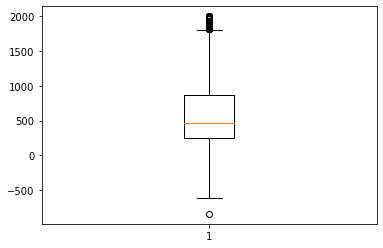

In [64]:
# outlier treatment for Amount
plt.boxplot(RFM.Amount)
Q1 = RFM.Amount.quantile(0.25)
Q3 = RFM.Amount.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Amount >= (Q1 - 1.5*IQR)) & (RFM.Amount <= (Q3 + 1.5*IQR))]



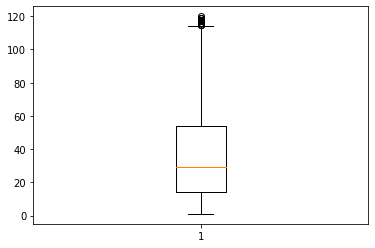

In [65]:
# outlier treatment for Frequency
plt.boxplot(RFM.Frequency)
Q1 = RFM.Frequency.quantile(0.25)
Q3 = RFM.Frequency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Frequency >= Q1 - 1.5*IQR) & (RFM.Frequency <= Q3 + 1.5*IQR)]


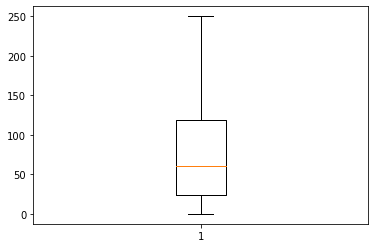

In [66]:
# outlier treatment for Recency
plt.boxplot(RFM.Recency)
Q1 = RFM.Recency.quantile(0.25)
Q3 = RFM.Recency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Recency >= Q1 - 1.5*IQR) & (RFM.Recency <= Q3 + 1.5*IQR)]


In [67]:
# Drop the outliers according to the box plot
RFM_norm1 = RFM.drop(RFM[RFM['Amount'] > 2000].index, inplace=True)
RFM_norm1 = RFM.drop(RFM[RFM['Frequency'] > 120].index, inplace=True)
RFM_norm1 = RFM.drop(RFM[RFM['Recency'] > 250].index, inplace=True)

After removing the outliers now we have 2810 unique users in our data frame

In [72]:
RFM

,UserID,Frequency,Amount,Recency
2,12348.0,31,1797.24,75
3,12349.0,73,1757.55,18
5,12352.0,95,1545.41,36
6,12353.0,4,89.00,204
7,12354.0,58,1079.40,232
...,...,...,...,...
4359,18278.0,9,173.90,73
4361,18281.0,7,80.82,180
4362,18282.0,13,176.60,7
4369,1725481.0,28,345.66,58


In [73]:
RFM_norm1 = RFM.drop(["UserID"], axis=1)

In [74]:
RFM_norm1

,Frequency,Amount,Recency
2,31,1797.24,75
3,73,1757.55,18
5,95,1545.41,36
6,4,89.00,204
7,58,1079.40,232
...,...,...,...
4359,9,173.90,73
4361,7,80.82,180
4362,13,176.60,7
4369,28,345.66,58


Scale the data in RFM_norm1

In [77]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
RFM_norm1 = standard_scaler.fit_transform(RFM_norm1)

RFM_norm1 = pd.DataFrame(RFM_norm1)
RFM_norm1.columns = ['Frequency','Amount','Recency']
RFM_norm1.head()

,Frequency,Amount,Recency
0,-0.193775,2.787105,-0.055725
1,1.309995,2.696422,-0.934908
2,2.097683,2.211729,-0.657271
3,-1.160484,-1.115846,1.934005
4,0.772934,1.146999,2.365885


Plot the **Sum of Squared Error** curve

Text(0.5, 1.0, 'SSE')

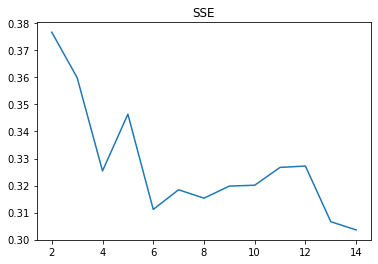

In [78]:
from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k).fit(RFM_norm1)
    sse_.append([k, silhouette_score(RFM_norm1, kmeans.labels_)])


plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);  # ERRor
plt.title('SSE')


Plot the **Sum of Squared Distance** curve also known as a elbow curve

Text(0.5, 1.0, 'SSD')

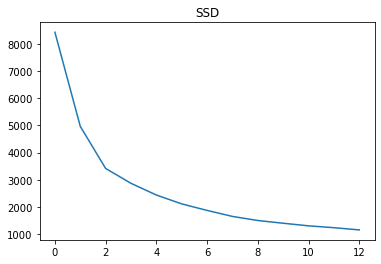

In [79]:
ssd = []
for num_clusters in list(range(1,14)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=100)
    model_clus.fit(RFM_norm1)
    ssd.append(model_clus.inertia_)
plt.plot(ssd)
plt.title('SSD')



From above graphs, we see the first significant change happens when number of clusters equals to 3

In [80]:
# So set Kmeans with K=3
model_clus3 = KMeans(n_clusters = 3, max_iter=100)  #final cluster 
model_clus3.fit(RFM_norm1)

KMeans(max_iter=100, n_clusters=3)

In [82]:
RFM_km2 = pd.concat([RFM_norm1, pd.Series(model_clus3.labels_)], axis=1)
RFM_km2.columns = [ 'Frequency', 'Amount', 'Recency', 'ClusterID']
RFM_km2

,Frequency,Amount,Recency,ClusterID
0,-0.193775,2.787105,-0.055725,0
1,1.309995,2.696422,-0.934908,0
2,2.097683,2.211729,-0.657271,0
3,-1.160484,-1.115846,1.934005,1
4,0.772934,1.146999,2.365885,1
...,...,...,...,...
2805,-0.981464,-0.921868,-0.086573,2
2806,-1.053072,-1.134535,1.563823,1
2807,-0.838248,-0.915699,-1.104575,2
2808,-0.301187,-0.529435,-0.317937,2


In [85]:
RFM_km2 = RFM_km2.dropna()
RFM_km2

,Frequency,Amount,Recency,ClusterID
0,-0.193775,2.787105,-0.055725,0
1,1.309995,2.696422,-0.934908,0
2,2.097683,2.211729,-0.657271,0
3,-1.160484,-1.115846,1.934005,1
4,0.772934,1.146999,2.365885,1
...,...,...,...,...
2805,-0.981464,-0.921868,-0.086573,2
2806,-1.053072,-1.134535,1.563823,1
2807,-0.838248,-0.915699,-1.104575,2
2808,-0.301187,-0.529435,-0.317937,2


In [86]:
km_clusters_amount11 = 	pd.DataFrame(RFM_km2.groupby(["ClusterID"]).Amount.mean())
km_clusters_frequency11 = 	pd.DataFrame(RFM_km2.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency11 = 	pd.DataFrame(RFM_km2.groupby(["ClusterID"]).Recency.mean())
RFM_km2.head()

,Frequency,Amount,Recency,ClusterID
0,-0.193775,2.787105,-0.055725,0
1,1.309995,2.696422,-0.934908,0
2,2.097683,2.211729,-0.657271,0
3,-1.160484,-1.115846,1.934005,1
4,0.772934,1.146999,2.365885,1


In [87]:
df11 = pd.concat([pd.Series([0,1,2]), km_clusters_amount11, km_clusters_frequency11, km_clusters_recency11], axis=1)
df11.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df11.info()
df11.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ClusterID       3 non-null      int64  
 1   Amount_mean     3 non-null      float64
 2   Frequency_mean  3 non-null      float64
 3   Recency_mean    3 non-null      float64
dtypes: float64(3), int64(1)
memory usage: 224.0 bytes


,ClusterID,Amount_mean,Frequency_mean,Recency_mean
0,0,1.167804,1.177920,-0.451292
1,1,-0.559533,-0.563539,1.295000
2,2,-0.420260,-0.424453,-0.545145


[Text(0.5, 1.0, 'Amount mean for each Cluster')]

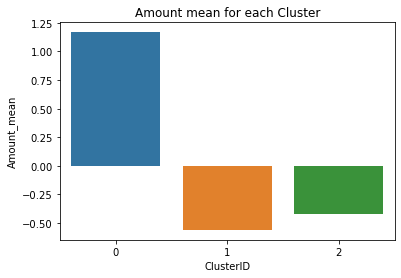

In [88]:

sns.barplot(x=df11.ClusterID, y=df11.Amount_mean).set(title='Amount mean for each Cluster')


[Text(0.5, 1.0, 'Frequency mean for each Cluster')]

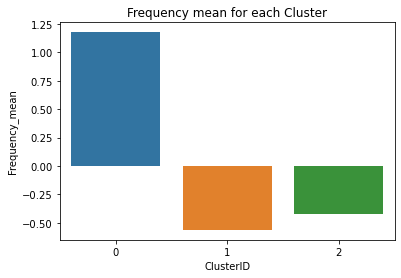

In [89]:
sns.barplot(x=df11.ClusterID, y=df11.Frequency_mean).set(title='Frequency mean for each Cluster')

[Text(0.5, 1.0, 'Recency mean for each Cluster')]

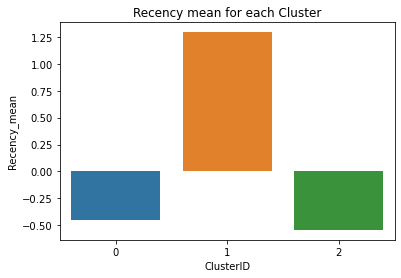

In [90]:
sns.barplot(x=df11.ClusterID, y=df11.Recency_mean).set(title='Recency mean for each Cluster')

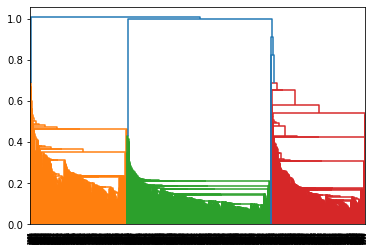

In [92]:
mergings = linkage(RFM_km2, method = "single", metric='euclidean')
dendrogram(mergings)
plt.show()

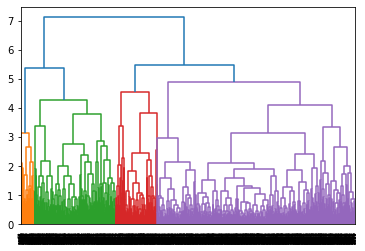

In [94]:
mergings = linkage(RFM_km2, method = "complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [96]:
clusterCut = pd.Series(cut_tree(mergings, n_clusters = 3).reshape(-1,))
RFM_hc = pd.concat([RFM_norm1, clusterCut], axis=1)
RFM_hc.columns = [ 'Frequency', 'Amount', 'Recency', 'ClusterID']
RFM_hc = RFM_hc.dropna()
RFM_hc

,Frequency,Amount,Recency,ClusterID
0,-0.193775,2.787105,-0.055725,0
1,1.309995,2.696422,-0.934908,0
2,2.097683,2.211729,-0.657271,0
3,-1.160484,-1.115846,1.934005,1
4,0.772934,1.146999,2.365885,1
...,...,...,...,...
2805,-0.981464,-0.921868,-0.086573,2
2806,-1.053072,-1.134535,1.563823,2
2807,-0.838248,-0.915699,-1.104575,2
2808,-0.301187,-0.529435,-0.317937,2


In [98]:
km_clusters_amount2 = 	pd.DataFrame(RFM_hc.groupby(["ClusterID"]).Amount.mean())
km_clusters_amount2


,Amount
ClusterID,
0,1.170058
1,-0.448210
2,-0.470329


In [99]:
km_clusters_frequency2 = 	pd.DataFrame(RFM_hc.groupby(["ClusterID"]).Frequency.mean())
km_clusters_frequency2


,Frequency
ClusterID,
0,1.173528
1,-0.302529
2,-0.502418


In [100]:
km_clusters_recency2 = 	pd.DataFrame(RFM_hc.groupby(["ClusterID"]).Recency.mean())
km_clusters_recency2

,Recency
ClusterID,
0,-0.482328
1,1.898312
2,-0.163880


In [104]:
df2 = pd.concat([pd.Series([0,1,2]), km_clusters_amount2, km_clusters_frequency2, km_clusters_recency2], axis=1)
df2.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df2

,ClusterID,Amount_mean,Frequency_mean,Recency_mean
0,0,1.170058,1.173528,-0.482328
1,1,-0.448210,-0.302529,1.898312
2,2,-0.470329,-0.502418,-0.163880


[Text(0.5, 1.0, 'Amount mean for each Cluster')]

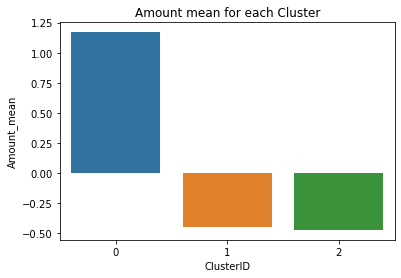

In [105]:
sns.barplot(x=df2.ClusterID, y=df2.Amount_mean).set(title='Amount mean for each Cluster')



[Text(0.5, 1.0, 'Frequency mean for each Cluster')]

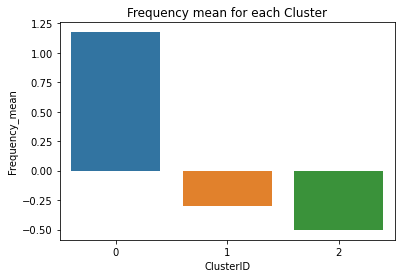

In [106]:
sns.barplot(x=df2.ClusterID, y=df2.Frequency_mean).set(title='Frequency mean for each Cluster')


[Text(0.5, 1.0, 'Recency mean for each Cluster')]

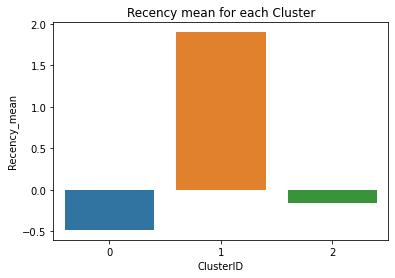

In [107]:

sns.barplot(x=df2.ClusterID, y=df2.Recency_mean).set(title='Recency mean for each Cluster')


/var/folders/vm/t0kfdtyd4j976j7k67x7nvpw0000gn/T/ipykernel_16517/182038191.py:6: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax=Axes3D(figure,elev=30,azim=150)


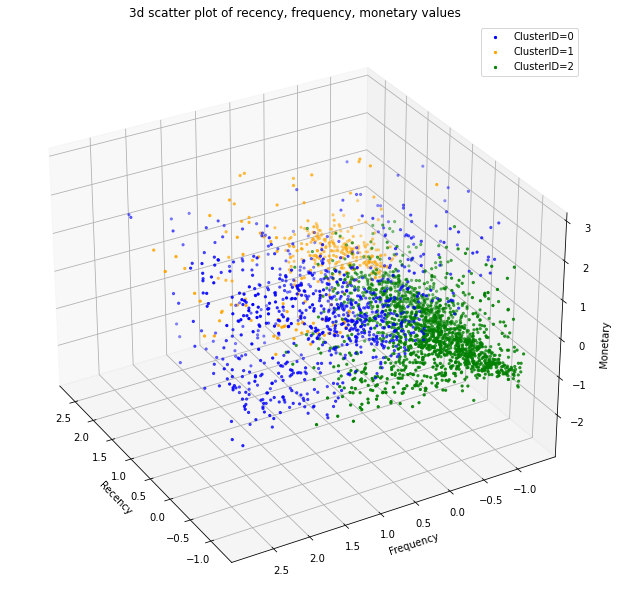

In [108]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D,axes3d


figure=plt.figure(figsize=(12,7))
ax=Axes3D(figure,elev=30,azim=150)


RFM_km_group1 = RFM_hc[RFM_hc['ClusterID']==0]
RFM_km_group2 = RFM_hc[RFM_hc['ClusterID']==1]
RFM_km_group3 = RFM_hc[RFM_hc['ClusterID']==2]


figure.set_size_inches(8,10)

ax.scatter(RFM_km_group1.loc[:,['Recency']],
RFM_km_group1.loc[:,['Frequency']],
RFM_km_group1.loc[:,['Amount']],s=5,c = 'blue' )

ax.scatter(RFM_km_group2.loc[:,['Recency']],
           RFM_km_group2.loc[:,['Frequency']],
           RFM_km_group2.loc[:,['Amount']],s=5,c = 'orange')

ax.scatter(RFM_km_group3.loc[:,['Recency']],
           RFM_km_group3.loc[:,['Frequency']],
           RFM_km_group3.loc[:,['Amount']],s=5,c = 'green')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.legend(map(lambda x:str(x),range(0,3)))
plt.legend(['ClusterID=0','ClusterID=1','ClusterID=2'])
plt.title('3d scatter plot of recency, frequency, monetary values')

plt.show()

In [ ]:
ALL the users in group zero appears to be the most valueable users since they contains the highest moteary value, highest frequency value and least rencency value.\
Users in group one and two appears to be the less active users, I suggest to try a diffen